In [1]:
import vaex as vx
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import ParameterGrid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from data_struct import dtypes
%matplotlib widget
%load_ext line_profiler

In [2]:
path = os.getcwd()

In [3]:
# Imports data
parse_dates = ['Sale Date', 'Sale Day', 'Sale Date Local']

#custom_dates = lambda x: parser.parse(x) or pd.to_datetime
#You can try both to check speed of import
try:
    data = vx.open('%s//Data//consumption_data.csv.hdf5'%path)
except (FileNotFoundError):
    data = vx.from_csv('%s//Data//consumption_data.csv'%path, 
                       dtype=dtypes, parse_dates=parse_dates, date_parser=pd.to_datetime,
            chunk_size=100_000, convert=True)

In [5]:
# Viewing Data
display(data.head())

#,Service Transaction ID,Sale ID,Sale Date,Sale Item ID,Sale Facility Country,Sale Day,Sale Facility,Sale Facility ID,Mph Arma ID,Customer Type,Vdl Drug ID,Vdl Drug Display Name,Unit Selling Price Local,Unit Selling Price Usd,Quantity In Units,Quantity In Packs,Sale Item Selling Price Local,Sale Item Selling Price Usd,Unit Vm I Cost Price Local,Sale Item Vm I Cost Price Local,Sale Item Vm I Cost Price Usd,Sale Item Vm I Margin Local,Sale Item Vm I Margin Usd,Unit Cost Price Local,Unit Cost Price Usd,Sale Item Cost Price Local,Sale Item Cost Price Usd,Sale Item Margin Local,Sale Item Margin Usd,Payment Method Type,Payment Timing Type,Product ID,Product Name,Product Alias ID,Product Alias Name,Patient Facility ID,Patient Facility Name,Patient Risk Tier Type,Corporate Facility Name,Customer Corporate Type,Facility Country,Sale Date Local,Item Category,Item Sub Category,Insurance Pay Or,Product Source,Vat Local (for The It Em),Vat Usd (for The It Em),Is Manual,Receipt ID,How Its Sold,Is Off Formula Ry,Mv Drug Abc → Country,Mv Drug Abc → Class,Mv Drug Abc → Class By Value,Mv Drug Abc → Class By Quantity,Mv Drug Abc → Class By Transaction Count,Mv Drug Abc → Class By Margin
0,91448,53b21d1b-5f91-4498-81cc-c5c78e5296b8,2020-02-22 20:39:03.550000000,10634,Ghana,2020-02-22 00:00:00.000000000,3A HEALTH,5e4a8e5ded73cf0076d21dfc,3670829,guest,165693,LONART DS x1,15.93,2.99195,1,1,15.93,2.99195,0,0,0,15.93,2.99195,0,0,0,0,15.93,2.99195,Cash,Time of Sale,d3d12db6-c8ac-4bad-9275-0df1bf542501,LONART DS x1,eeddbfa9-c5c5-4e07-bcc8-73b75a8567b7,LONART DS x1,5e4a8e5ded73cf0076d21dfc,3A HEALTH,No Policy,--,guest,Ghana,2020-02-22 20:39:03.550000000,DRUGS,Anti-Infectives,None,formulary,0,0,false,1DFC-0000000001,TABLET,false,Ghana,A,A,B,A,A
1,91466,456beab8-433b-43f1-ba0c-0b9a3c62ca45,2020-02-22 13:07:50.726000000,10647,Ghana,2020-02-22 00:00:00.000000000,Narteva Pharmacy,5e4a8caded73cf0076d21df4,9616396,member,228432,LOFNAC 100MG TAB 10'S x20,1.25,0.234773,1,0.05,1.25,0.234773,0,0,0,1.25,0.234773,0,0,0,0,1.25,0.234773,Cash,Time of Sale,09e94d4e-d77e-4b03-8f18-23e7df323d7e,LOFNAC 100MG TAB 10'S x20,e87b0b20-dcd5-4ba7-84df-b55895d96b4f,LOFNAC 100MG TAB 10'S x20,5e4a8caded73cf0076d21df4,Narteva Pharmacy,No Policy,--,non-corporate member,Ghana,2020-02-22 13:07:50.726000000,DRUGS,Analgesics,None,formulary,0,0,false,1DF4-0000000011,TABLET,false,Ghana,A,B,B,A,B
2,91494,8b87d8fa-12d6-43c2-93ad-5fecc1edb1f6,2020-02-22 21:48:41.710000000,10662,Ghana,2020-02-22 00:00:00.000000000,3A HEALTH,5e4a8e5ded73cf0076d21dfc,3670829,guest,165649,FERROUS SULPHATE x28 UK,0.39,0.0732493,2,0.0714286,0.78,0.146499,0,0,0,0.78,0.146499,0,0,0,0,0.78,0.146499,Cash,Time of Sale,86bfb6d9-89b2-48a3-8ccd-db0835ab1c94,FERROUS SULPHATE x28 UK,3aa1c70f-3bf9-4fd2-a5e2-b3a5ea1c084c,FERROUS SULPHATE x28 UK,5e4a8e5ded73cf0076d21dfc,3A HEALTH,No Policy,--,guest,Ghana,2020-02-22 21:48:41.710000000,DRUGS,Supplements,None,formulary,0,0,false,1DFC-0000000019,TABLET,false,--,--,--,--,--,--
3,91507,9a27e282-45f6-40ef-8662-29c2f689e07c,2020-02-22 22:05:22.955000000,10667,Ghana,2020-02-22 00:00:00.000000000,3A HEALTH,5e4a8e5ded73cf0076d21dfc,3670829,guest,169837,CITRO-C 100MG x25,1.66,0.311779,2,0.08,3.32,0.623558,0,0,0,3.32,0.623558,0,0,0,0,3.32,0.623558,Cash,Time of Sale,b0337df8-f7fb-4ef4-83d9-8e087933ab4e,CITRO-C 100MG x25,8f5adcea-420b-49fb-a22f-b76b3802cbbf,CITRO-C 100MG x25,5e4a8e5ded73cf0076d21dfc,3A HEALTH,No Policy,--,guest,Ghana,2020-02-22 22:05:22.955000000,DRUGS,Supplements,None,formulary,0,0,false,1DFC-0000000022,TABLET,false,Ghana,A,A,B,A,B
4,91567,fd0be28a-8748-46fa-8765-669dbf127076,2020-02-22 15:14:34.437000000,10705,Ghana,2020-02-22 00:00:00.000000000,Narteva Pharmacy,5e4a8caded73cf0076d21df4,2051523,member,234450,MULTIVITAMIN TABS BLISTER 10'S x50,0.22,0.0413201,30,0.6,6.6,1.2396,0,0,0,6.6,1.2396,0,0,0,0,6.6,1.2396,Cash,Time of Sale,0b6cd367-9015-49b4-8cdf-e8b5234d3183,MULTIVITAMIN TABS BLISTER 10'S x50,8eee24aa-399f-4a03-9e6f-beb4633c248f,MULTIVITAMIN TABS BLISTER 10'S x50,5e4a8

In [6]:
# Place all Column Names in a List
col_names = data.get_column_names()
# Renaming all columns to fit Vaex standards
for i in col_names:
    data.rename(i,i.replace(" ", "_").replace("-","_"))


In [104]:
data.info()

column,type,unit,description,expression
Service_Transaction_ID,str,,,
Sale_ID,str,,,
Sale_Date,datetime64[ns],,,
Sale_Item_ID,str,,,
Sale_Facility_Country,str,,,
Sale_Day,datetime64[ns],,,
Sale_Facility,str,,,
Sale_Facility_ID,str,,,
Mph_Arma_ID,str,,,
Customer_Type,str,,,


In [9]:
col_names = data.get_column_names()

# Filtering Data to relevant Columns
df = data.copy()[[col_names[2], col_names[4], col_names[5], col_names[6], 
                col_names[9], col_names[10], col_names[11], col_names[12], col_names[13],
                col_names[14], col_names[15],col_names[41], col_names[43], col_names[44], col_names[50]]]

In [10]:
# Viewing the Relevant Columns
df.get_column_names()
# Sort Time Series
df = df.sort(by='Sale_Date', ascending=True)

In [19]:
indications = dict(df.groupby('Item_Sub_Category'))
anti_d = indications[('Anti-Diabetics',)]
anti_d = vx.from_arrays(x=anti_d['Sale_Date'].values,y=anti_d['Quantity_In_Units'].values)
anti_d.rename("x", "Sale_Date")
anti_d.rename("y", "Quantity_In_Units")

'Quantity_In_Units'

**ANALYZING PER FACILITY**

In [49]:
#For mock purposes we will go with the facility with the highest number of rows

count = 0
for facility in df['Sale_Facility'].unique():
    if len(df[df['Sale_Facility']==facility]) > count:
        count = len(df[df['Sale_Facility']==facility])
        largest = facility

print(f"{largest} is the largest facility in terms of volume of transactions with  {count} transactions")


Emboch Chemist is the largest facility in terms of volume of transactions with  75022 transactions


In [51]:
#Using the same idea to get the Item with the highest volume of transactions on
fty_df = df[df['Sale_Facility'] == largest]

count = 0
for item_class in df['Item_Sub_Category'].unique():
    if len(df[df['Item_Sub_Category'] == item_class]) > count:
        count = len(df[df['Item_Sub_Category'] == item_class])
        largest = item_class

print(f"{largest} are sold more often with {count} volume of transactions")


no data are sold more often with 156411 volume of transactions


In [53]:
#Since no data represents medications with no class intuitive conclusions cant be draw with regards to class.
#Lets go with Contraceptives instead

con_df = fty_df[fty_df['Item_Sub_Category'] == 'Contraceptives']

In [88]:
#Split the data into the respective Date Frequencies eg. Yearly, Monthly, Weekly, Daily, Hourly
#We are using quantity in Units because you can derive the pack size from it

freq_dict = {}
for i in zip(['h', 'D', 'W', 'M'], ['hourly', 'daily', 'weekly', 'monthly']):
    freq_dict[i[1]] = con_df.groupby(by=vx.BinnerTime(con_df['Sale_Date'], resolution=i[0]), agg={'Quantity_In_Units':'sum'})


In [63]:
con_df.shape[-1]

15

**PREPROCESSING AND VISUALIZATION**

In [77]:
#Develop in house function for rolling means/std since vaex has no inbuilt function for this

def rolling_window(a, window, find_mean, find_std):
    old_shape = a.shape[0]
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    view = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    
    if find_mean:
        final = np.array([view[i,:].mean() for i in range(view.shape[0])])
        
    elif find_std:
        final = np.array([view[i,:].std() for i in range(view.shape[0])])
        
    new_shape = view.shape[0]
    zeros = np.array([0 for x in range(old_shape - new_shape)])
    result = np.concatenate((zeros,final))
    return result

In [85]:
#Build function for plots to showcase the rolling window and SavGol

def plots(x, y, title, window=3, ylabel='Quantity Sold in Units', mean=False, std=False, sav=False):
    date="%b, %d %Y"
    xlabel='Date'
    
    fig = plt.figure()
    plt.plot_date(x, y, linestyle='solid', marker=None, fmt='g', label='Main Time Series Data')
    if sav:
        plt.plot_date(x, savgol_filter(y,window,3),
                      linestyle='solid', marker=None, fmt='y', label='Saviztky Golay Algo with Window Size of %s'%window)
    if mean:
        plt.plot_date(x, rolling_window(y,window=window,find_mean=True,find_std=False),
                      linestyle='solid', marker=None, fmt='r', label='Moving Average with Window Size of %s'%window)
    if std:
        plt.plot_date(x, rolling_window(y,window=window,find_std=True, find_mean=False),
                      linestyle='solid', marker=None, fmt='b', label='Moving Std with Window Size of %s'%window)
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter(date)
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
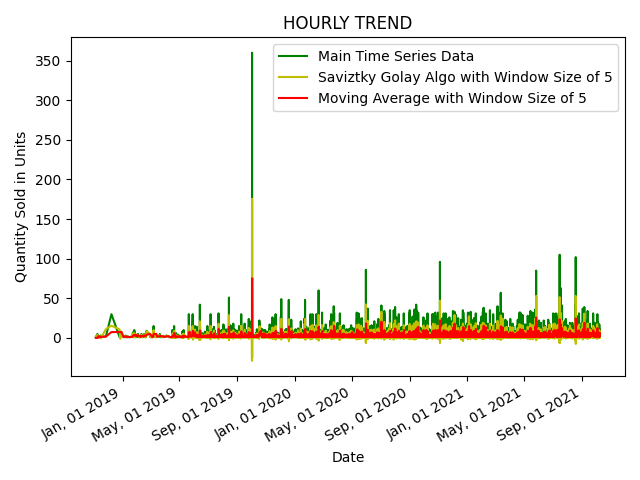

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
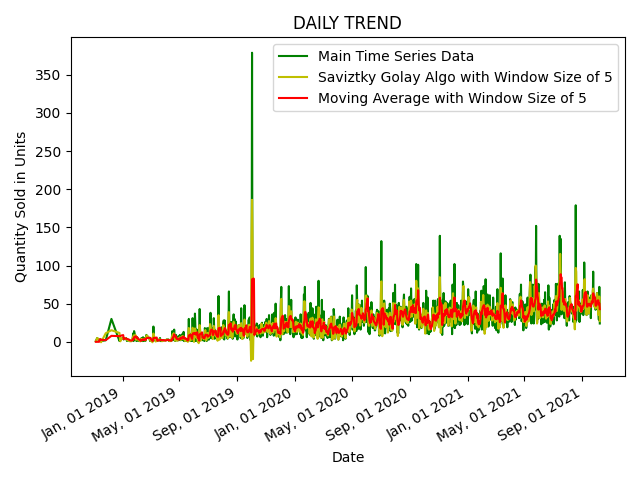

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
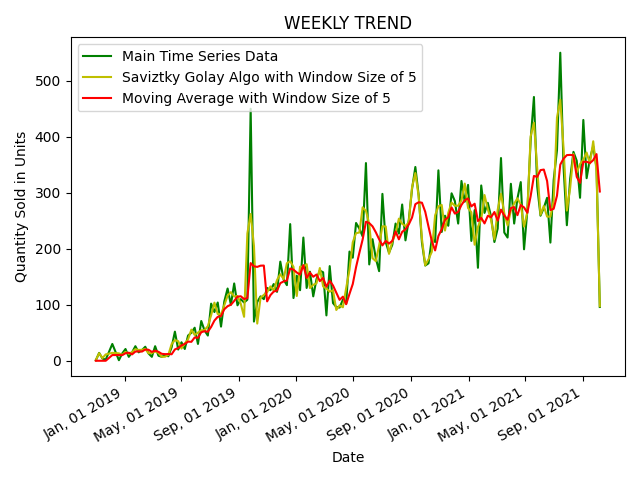

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
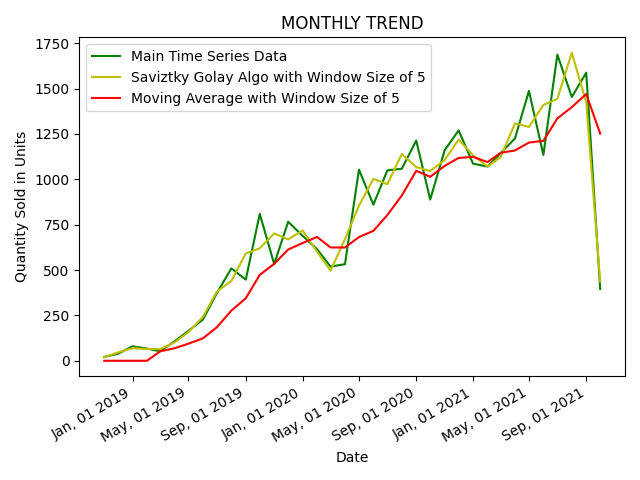

In [89]:
for freq in freq_dict.keys():
    plots(freq_dict[freq]['Sale_Date'].values, freq_dict[freq]['Quantity_In_Units'].values,
          f'{freq} Trend'.upper(),5, mean=True, sav=True)

**Stationarity**

In [91]:
# Adfuller Test to Check for Stationary Datasets
def stat_check(data, ts):
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic', 'P-value', '#lags used', 'Number of Observations Used'])
    for key,value in test[4].items():
        results['Critical Value (%s)'%key] = value
    
    print(f'Results of Dickey Fuller Test for {ts} Data \n{results}')


for freq in freq_dict.keys():
    stat_check(freq_dict[freq]['Quantity_In_Units'].values, freq.upper())



Results of Dickey Fuller Test for HOURLY Data 
Test Statistic                  -88.906410
P-value                           0.000000
#lags used                        0.000000
Number of Observations Used    8362.000000
Critical Value (1%)              -3.431132
Critical Value (5%)              -2.861886
Critical Value (10%)             -2.566954
dtype: float64
Results of Dickey Fuller Test for DAILY Data 
Test Statistic                  -2.554919
P-value                          0.102677
#lags used                      15.000000
Number of Observations Used    966.000000
Critical Value (1%)             -3.437138
Critical Value (5%)             -2.864537
Critical Value (10%)            -2.568366
dtype: float64
Results of Dickey Fuller Test for WEEKLY Data 
Test Statistic                  -1.177718
P-value                          0.683107
#lags used                       8.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)      

In [95]:
# One means of ensuring stationarity is decomposing and taking the residuals
def decompose(data, t_series, period):
    result = seasonal_decompose(data, period=12)
    plots(t_series, result.trend, 'Trend')
    plots(t_series, result.seasonal, 'Seasonality')
    plots(t_series, result.resid, 'Residuals')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
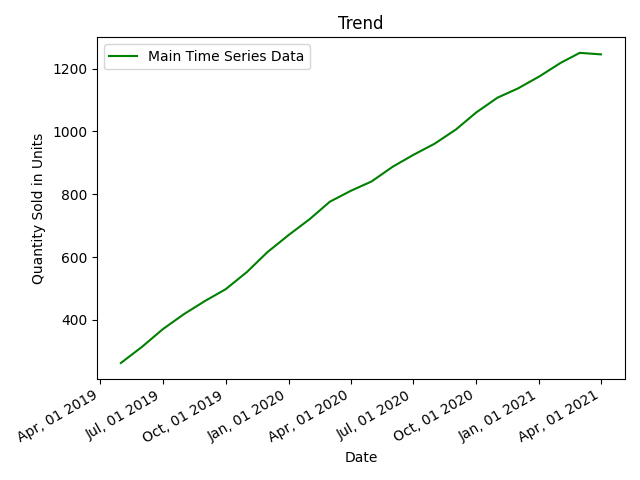

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
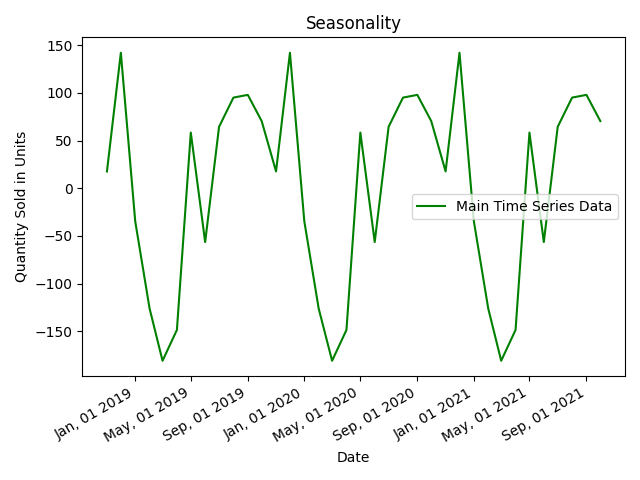

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
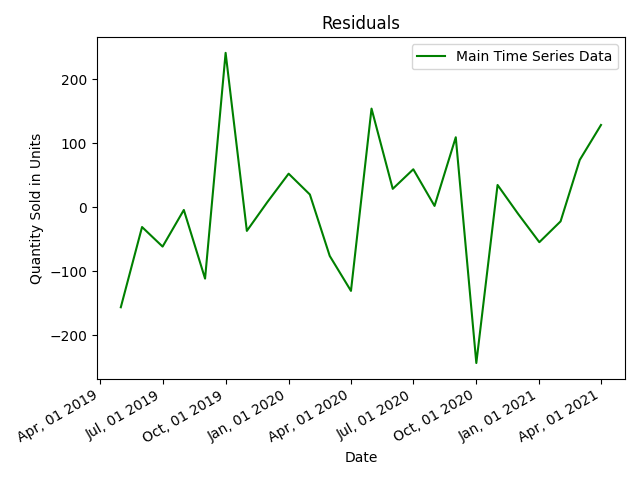

In [101]:
decompose(freq_dict['monthly']['Quantity_In_Units'].values, freq_dict['monthly']['Sale_Date'].values, period=12)

In [ ]:
monthly = vx.from_arrays(x=monthly["Sale_Date"].values, y=monthly["count"].values)
monthly.rename("x","Sale_Date")
monthly.rename("y","count")

In [ ]:
# Transforming data to ensure stationarity (Log/MA)
monthly['log_data'] = monthly['count'].apply(lambda x: np.log(x))

In [ ]:
monthly.head()

In [ ]:
log_ma = rolling_window(monthly['log_data'].values, 12, find_mean=True, find_std=False)

In [ ]:
plots(monthly['Sale_Date'].values, monthly['log_data'].values, 'Monthly Trend', mean=True, window=12)
stat_check(anti_d['log_data'].values, "Monthly")
# plots(monthly['Sale_Date'].values, rolling_window(monthly['log_data'].values, 12,
#                                                  find_mean=True, find_std=False), "%b, %d %Y", 'Monthly Trend', 5)
stat_check(log_ma, "Mean Log")

In [ ]:
# Differencing
def diff(dataset, interval, col):
    result = []
    for i in range(interval, len(dataset)):
        offset = i - interval
        value = dataset[col].values[i] - dataset[col].values[offset]
        result.append(value)
    return (result)

%lprun -f diff diff(dataset=anti_d, interval=1, col="log_data")

In [ ]:
jot = monthly.diff(column="log_data", fill_value="nan")

In [ ]:
monthly.diff(column="log_data", fill_value="nan")

In [ ]:
monthly["diff"] = jot["log_data"].values

In [ ]:
stat_check(anti_d["log_diff"].values)

In [ ]:
# Determing p and q
lag_acf = acf(anti_d["Quantity_In_Units"].values, nlags=20)
lag_pacf = pacf(anti_d["Quantity_In_Units"].values, nlags=20)

In [ ]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()  
  return

In [ ]:
plot_acf_pacf(anti_d["Quantity_In_Units"].values, "Data")

In [ ]:
fig,(ax1,ax2)= plt.subplots(1, 2)
ax1 = plot_acf(anti_d["Quantity_In_Units"].values, lags=40, ax=ax1)
ax2 = plot_pacf(anti_d["Quantity_In_Units"].values, lags=40, ax=ax2)

In [ ]:
def run_arima_model(df, dates, p, d, q):
  """
  Run ARIMA model
  """

  # fit ARIMA model on time series
  model = ARIMA(df, order=(p, d, q))  
  results_ = model.fit()  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df))
  
  # plot fit
  fig = plt.figure()
  plt.plot(dates, df)
  plt.plot(dates, results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for RSS: %.4f, RMSE: %.4f' %(p, d, q, rss, rmse))
  
  plt.show()  
  return results_

In [ ]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 1, 
                           d = 0, 
                           q = 1)

In [ ]:
ARIMA(anti_d.Quantity_In_Units.values).fit(disp=-1)

In [ ]:
results = ARIMA(anti_d.Quantity_In_Units.values).fit()

In [ ]:
plt.results.fittedvalues